https://pylessons.com/CartPole-reinforcement-learning/

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import random
import gym #/.local/lib/python3.6/site-packages/gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='CartPole_DQN_model')
    model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

class DQNAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        # by default, CartPole-v1 has max episode steps = 500
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 1000        
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000

        # create main model
        self.model = OurModel(input_shape=(self.state_size,), action_space = self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)

        for i in range(self.batch_size):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # Q_max = max_a' Q_target(s', a')
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)


    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)
            
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:                   
                    print("episode: {}/{}, score: {}, e: {:.2}".format(e, self.EPISODES, i, self.epsilon))
                    if i == 500:
                        print("Saving trained model as cartpole-dqn.h5")
                        self.save("cartpole-dqn.h5")
                        return
                self.replay()

    def test(self):
        self.load("cartpole-dqn.h5")
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break

In [3]:
#if __name__ == "__main__":
agent = DQNAgent()
agent.EPISODES = 25
agent.run()

Model: "CartPole_DQN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 150,466
Trainable params: 150,466
Non-trainable params: 0
_________________________________________________________________
episode: 0/25, score: 43, e: 1.0
episode: 1/25, score: 16, e: 1.0
episode: 2/25, score: 45, e: 1.0
episode: 

In [4]:
agent.save("cartpole-dqn.h5")

In [5]:
agent.test()

episode: 0/25, score: 10
episode: 1/25, score: 9
episode: 2/25, score: 9
episode: 3/25, score: 11
episode: 4/25, score: 9
episode: 5/25, score: 10
episode: 6/25, score: 8
episode: 7/25, score: 10
episode: 8/25, score: 9
episode: 9/25, score: 9
episode: 10/25, score: 10
episode: 11/25, score: 10
episode: 12/25, score: 9
episode: 13/25, score: 8
episode: 14/25, score: 9
episode: 15/25, score: 9
episode: 16/25, score: 8
episode: 17/25, score: 9
episode: 18/25, score: 9
episode: 19/25, score: 8
episode: 20/25, score: 10
episode: 21/25, score: 9
episode: 22/25, score: 10
episode: 23/25, score: 9
episode: 24/25, score: 8


In [13]:
agent.env.state

(-0.10907240379299253,
 -1.572361264312239,
 0.21147441236307393,
 2.53671850971638)

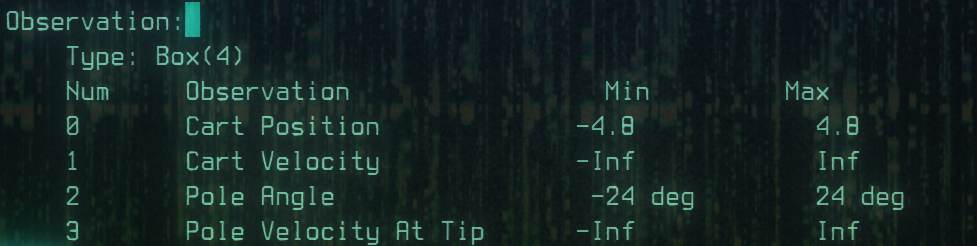